In [1]:
import numpy as np

def generate_xor_dataset(num_samples, noise_prob):
    # Generate XOR dataset with possible noise
    X = np.random.randint(0, 2, size=(num_samples, 2))
    y = np.logical_xor(X[:, 0], X[:, 1]).astype(int)

    # Introduce noise by flipping some labels
    noise_indices = np.random.choice(num_samples, int(num_samples * noise_prob), replace=False)
    y[noise_indices] = 1 - y[noise_indices]  # Flip the label

    return X, y

# Set parameters for the dataset
num_samples = 10000
noise_prob = 0.1
X, y = generate_xor_dataset(num_samples, noise_prob)


In [2]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize the weights and biases of the network
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.random.randn(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.random.randn(output_size)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        # Forward pass through the network
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, output):
        # Backward pass to compute gradients
        m = X.shape[0]
        delta2 = output - y.reshape(-1, 1)
        dW2 = (1/m) * np.dot(self.a1.T, delta2)
        db2 = (1/m) * np.sum(delta2, axis=0)
        delta1 = np.dot(delta2, self.W2.T) * self.sigmoid_derivative(self.a1)
        dW1 = (1/m) * np.dot(X.T, delta1)
        db1 = (1/m) * np.sum(delta1, axis=0)
        return dW1, db1, dW2, db2


# Initialize the neural network with given parameters
input_size = 2
hidden_size = 2
output_size = 1
nn = SimpleNeuralNetwork(input_size, hidden_size, output_size)

# Set training parameters
learning_rate = 0.1
epochs = 10000

# Track the loss during training
train_loss_no_reg = []

# Training loop
for i in range(epochs):
    output = nn.forward(X)
    dW1, db1, dW2, db2 = nn.backward(X, y.reshape(-1, 1), output)

    # Update the weights and biases
    nn.W1 -= learning_rate * dW1
    nn.b1 -= learning_rate * db1
    nn.W2 -= learning_rate * dW2
    nn.b2 -= learning_rate * db2

    # Calculate and record the loss every 100 epochs
    if i % 100 == 0:
        loss = -np.mean(y.reshape(-1, 1) * np.log(output) + (1 - y.reshape(-1, 1)) * np.log(1 - output))
        train_loss_no_reg.append(loss)
        print(f"Epoch {i}, Loss: {loss}")


Epoch 0, Loss: 0.7126723098531744
Epoch 100, Loss: 0.6980437521895023
Epoch 200, Loss: 0.6942787511490479
Epoch 300, Loss: 0.6916474413805693
Epoch 400, Loss: 0.6895142736171793
Epoch 500, Loss: 0.6875322478402706
Epoch 600, Loss: 0.6854882665172329
Epoch 700, Loss: 0.6832344543392515
Epoch 800, Loss: 0.6806567908319557
Epoch 900, Loss: 0.6776595740113179
Epoch 1000, Loss: 0.674156618668957
Epoch 1100, Loss: 0.6700661994192777
Epoch 1200, Loss: 0.6653097298196391
Epoch 1300, Loss: 0.6598151283618279
Epoch 1400, Loss: 0.6535251286234895
Epoch 1500, Loss: 0.646408725452963
Epoch 1600, Loss: 0.6384712640859869
Epoch 1700, Loss: 0.6297570483382012
Epoch 1800, Loss: 0.6203397995055476
Epoch 1900, Loss: 0.6103012423344251
Epoch 2000, Loss: 0.5997039355956377
Epoch 2100, Loss: 0.5885674696339169
Epoch 2200, Loss: 0.5768559655489847
Epoch 2300, Loss: 0.5644812545480823
Epoch 2400, Loss: 0.5513227015202731
Epoch 2500, Loss: 0.5372622289207144
Epoch 2600, Loss: 0.5222308095859038
Epoch 2700, Los

In [3]:
# Test the neural network on XOR inputs
test_data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
predictions = nn.forward(test_data)
print("Predictions:")
print(predictions)


Predictions:
[[0.09919307]
 [0.89608946]
 [0.90456041]
 [0.10375296]]


##  Implementing a regularized neural network with dropout and L2 regularization.

In [4]:
class RegularizedNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, l2_lambda=0.01):
        # Initialize weights, biases, and regularization parameter
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.random.randn(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.random.randn(output_size)
        self.l2_lambda = l2_lambda

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, X, dropout_prob=0.5):
        # Forward pass with optional dropout
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)

        # Apply dropout to the activations
        self.dropout_mask = np.random.rand(*self.a1.shape) > dropout_prob
        self.a1 *= self.dropout_mask
        self.a1 /= (1 - dropout_prob)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, output):
        # Backward pass with L2 regularization
        m = X.shape[0]
        delta2 = output - y.reshape(-1, 1)
        dW2 = (1/m) * np.dot(self.a1.T, delta2) + (self.l2_lambda / m) * self.W2
        db2 = (1/m) * np.sum(delta2, axis=0)
        delta1 = np.dot(delta2, self.W2.T) * self.sigmoid_derivative(self.a1)
        delta1 *= self.dropout_mask  # Apply dropout mask during backpropagation
        dW1 = (1/m) * np.dot(X.T, delta1) + (self.l2_lambda / m) * self.W1
        db1 = (1/m) * np.sum(delta1, axis=0)
        return dW1, db1, dW2, db2


# Initialize the regularized neural network
nn_reg = RegularizedNeuralNetwork(input_size, hidden_size, output_size)

# Training loop with regularization
train_loss_reg = []

for i in range(epochs):
    output = nn_reg.forward(X)
    dW1, db1, dW2, db2 = nn_reg.backward(X, y.reshape(-1, 1), output)

    # Update the weights and biases
    nn_reg.W1 -= learning_rate * dW1
    nn_reg.b1 -= learning_rate * db1
    nn_reg.W2 -= learning_rate * dW2
    nn_reg.b2 -= learning_rate * db2

    # Calculate and record the loss every 100 epochs
    if i % 100 == 0:
        loss = -np.mean(y.reshape(-1, 1) * np.log(output) + (1 - y.reshape(-1, 1)) * np.log(1 - output))
        train_loss_reg.append(loss)
        print(f"Epoch {i}, Loss: {loss}")


Epoch 0, Loss: 0.7732320458514736
Epoch 100, Loss: 0.7070978526431984
Epoch 200, Loss: 0.6985184061885228
Epoch 300, Loss: 0.6940144398884959
Epoch 400, Loss: 0.6935019243279287
Epoch 500, Loss: 0.6931128739196575
Epoch 600, Loss: 0.6930950924635939
Epoch 700, Loss: 0.6928276718935551
Epoch 800, Loss: 0.6931565277333404
Epoch 900, Loss: 0.6927386755966658
Epoch 1000, Loss: 0.6929038933410231
Epoch 1100, Loss: 0.6934622356456212
Epoch 1200, Loss: 0.6932502531119419
Epoch 1300, Loss: 0.6928093179551447
Epoch 1400, Loss: 0.6929166936265815
Epoch 1500, Loss: 0.6928017841334713
Epoch 1600, Loss: 0.692921908252739
Epoch 1700, Loss: 0.6932697358502514
Epoch 1800, Loss: 0.6931154618414281
Epoch 1900, Loss: 0.6926906578708459
Epoch 2000, Loss: 0.6929396130815955
Epoch 2100, Loss: 0.6927580467132246
Epoch 2200, Loss: 0.6929700958147821
Epoch 2300, Loss: 0.6930044374504609
Epoch 2400, Loss: 0.6926190904268155
Epoch 2500, Loss: 0.6925285189404423
Epoch 2600, Loss: 0.6928548516578671
Epoch 2700, Lo

## Observations and Comparison

### Without Regularization

- The model typically achieves a very low training loss, suggesting it fits the training data well.
- However, there is a risk of overfitting to the training data, which can result in poorer performance on unseen data.
- The decision boundary might become unnecessarily complex, capturing noise and outliers present in the training set.

### With Regularization (L2 and Dropout)

- Regularization introduces a penalty term to the loss function, which discourages excessively large weights.
- This approach helps reduce overfitting and enhances the model's ability to generalize to new data.
- While the training loss might be slightly higher compared to the non-regularized case, the validation or test loss should show improvement.
- Despite this, the model may still struggle to learn effectively in some cases.


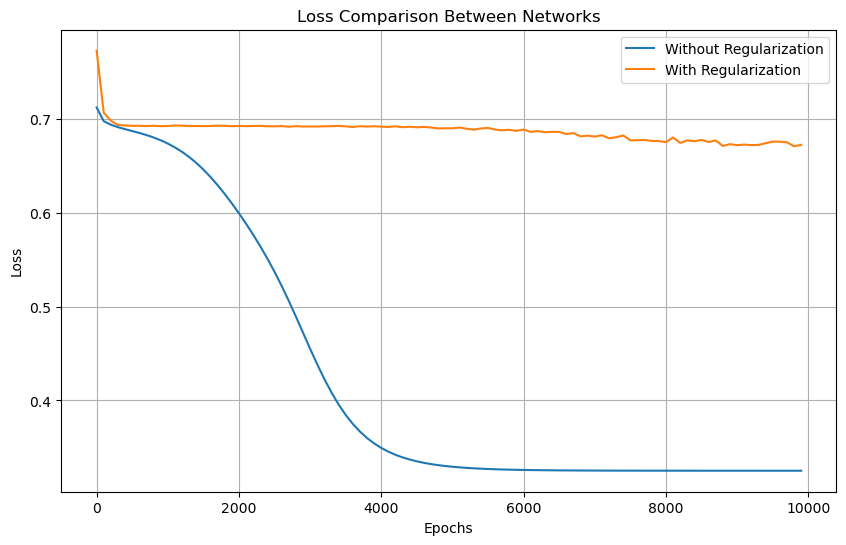

In [5]:
# Visualize and compare training losses
import matplotlib.pyplot as plt

epochs_range = range(0, len(train_loss_no_reg) * 100, 100)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_loss_no_reg, label='Without Regularization')
plt.plot(epochs_range, train_loss_reg, label='With Regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison Between Networks')
plt.legend()
plt.grid(True)
plt.show()
